In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

# enable 16 bit precision for jax                                                                                                                             
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import jit, grad, random

import numpyro
import numpyro.distributions as dist
MultivariateNormal = dist.MultivariateNormal
from numpyro.distributions import Normal
import optax

# Import GSM                                                                                                                                                  
import sys
sys.path.append('../gsmvi//')
from gsm import GSM
from bbvi import ADVI, Scorenorm, Fishernorm
#####                                                                                                                                                         
from initializers import lbfgs_init

# sys.path.append('../utils/')
# from monitors import KLMonitor_Gauss as Monitor

import tensorflow_probability as tfp
SinhArcsinh = tfp.substrates.jax.distributions.SinhArcsinh
MultivariateNormal_tf = tfp.substrates.jax.distributions.MultivariateNormalFullCovariance


/mnt/home/cmodi/miniconda3/envs/jaxenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from gsmvi.monitors import KLMonitor as Monitor



# BAM, BAM_lr

In [7]:
from bam import BAM
from gsm import GSM
from gsmvi.monitors import KLMonitor
from gsmvi.bam_lrproject import BAM_lrproject



In [8]:

##### Simple experiment for multivaraite Gaussian with dense covariance matrix
#####                                                                                                                                                         
def setup_model(D=10, rank=4):

    # setup a Gaussian target distribution                                                                                                                    
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)
    cov = np.matmul(L, L.T) + np.diag(np.random.normal(1, 1, D)*1e-1+1)
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples



D = 64
rank = 32
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)

lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [10]:
# alg = GSM(D, lp, lp_g)
# alg = GSM(D, lp_vmap, lp_g_vmap)
alg = BAM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)

monitor = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
meanfit, covfit = alg.fit(key,  batch_size=16, niter=100, regf=lambda x: 100, monitor=monitor)

Iteration 0 of 100
Iteration 10 of 100
Iteration 20 of 100
Iteration 30 of 100
Iteration 40 of 100
Iteration 50 of 100
Iteration 60 of 100
Iteration 70 of 100
Iteration 80 of 100
Iteration 90 of 100
Iteration 100 of 100


In [15]:
alg2 = BAM_lrproject(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)

monitor2 = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
meanfit2, covfit2 = alg2.fit(key, rank=8, batch_size=16, n_project=256, niter=200, regf=lambda x: 100, monitor=monitor2)

Iteration 0 of 200
Iteration 20 of 200
Iteration 40 of 200
Iteration 60 of 200
Iteration 80 of 200
Iteration 100 of 200
Iteration 120 of 200
Iteration 140 of 200
Iteration 160 of 200
Iteration 180 of 200
Iteration 200 of 200


19


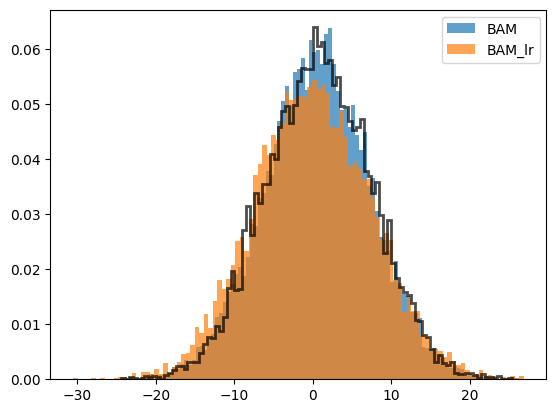

In [16]:
i = np.random.randint(D)
print(i)
plt.hist(np.random.multivariate_normal(meanfit, covfit, 10000)[..., i], bins=100, density=True, alpha=0.7, label='BAM');
plt.hist(np.random.multivariate_normal(meanfit2, covfit2, 10000)[..., i], bins=100, density=True, alpha=0.7, label='BAM_lr');
plt.hist(ref_samples[..., i], bins=100, density=True, alpha=0.7, histtype='step', lw=2, color='k');
plt.legend()

# Code development below

# code copied
Code taken from https://github.com/je-suis-tm/machine-learning/blob/master/factor%20analysis.ipynb

In [10]:
#get latent variables z
#andrew ng didnt teach us how to get the latent
#we have to borrow ideas from sklearn even though we dont know why
#alternatively
#x=miu+lambda_@z+epsilon
#z=inverse(lambda_)@(x-miu-epsilon)
#but this is incorrect
#as we dont know epsilon
#we can only assume its zero
#z=np.linalg.pinv(lambda_)@(data-miu).T
@jit
def get_latent(data,miu,lambda_,psi):
    
    psi_inv = jnp.diag(jnp.diagonal(psi)**-1)
    weighted_psi = lambda_.T@psi_inv
    cov_z = jnp.linalg.inv(jnp.identity(lambda_.shape[1])+weighted_psi@lambda_)
    z= (data - miu)@(weighted_psi).T@cov_z
    
    return z


#pdf of multivariate gaussian
#equivalent to scipy.stats.multivariate_normal(miu,sigma).pdf(data)
def multivariate_gaussian(data,miu,sigma):
    
    numerator=np.exp(-0.5*(data-miu)@np.linalg.inv(sigma)@(data-miu).T)
    denominator=(2*np.pi)**(data.shape[1]/2)*np.linalg.det(sigma)**0.5

    return np.diagonal(numerator/denominator)


#unlike gmm, only p(x|z) depends on the params
#thus the computation can be simplified
#although we have one more step of computing z
# def get_lower_bound(data,miu,lambda_,psi):
    
#     #transform x
#     z=get_latent(data,miu,lambda_,psi)

#     #logarithm multivariate gaussian
#     logpdf=np.log(multivariate_gaussian(data-(lambda_@z.T).T,miu,psi))    
#     lower_bound=sum(logpdf)
    
#     return lower_bound


@jit
def get_lower_bound(data, mu, llambda, psi):
    
    z = get_latent(data, mu, llambda, psi)    
    loc = (llambda@z.T).T
    scale = jnp.diag(psi)**0.5
    logpdf = Normal(loc, scale).log_prob(data)
    lower_bound = logpdf.sum()
    
    return lower_bound
    

In [11]:
# #e step
# #use lambda_ and psi to update conditional miu and sigma
# def e_step(data,miu,lambda_,psi):
    
#     #denote beta
#     beta=lambda_.T@np.linalg.inv(lambda_@lambda_.T+psi)

#     #compute conditional params
#     miu_z_given_x=beta@(data-miu).T
#     sigma_z_given_x=np.identity(lambda_.shape[1])-beta@lambda_
    
#     return miu_z_given_x,sigma_z_given_x

# #m step
# #use conditional miu and sigma to update lambda_,psi
# def m_step(data,miu,miu_z_given_x,sigma_z_given_x):

#     #equation 8 in stanford material
#     lambda_=(data-miu).T@miu_z_given_x.T@np.linalg.inv(miu_z_given_x@miu_z_given_x.T+sigma_z_given_x)

#     #last equation
#     phi=(data.T@data-2*data.T@miu_z_given_x.T@lambda_.T+ \
#          lambda_@(miu_z_given_x@miu_z_given_x.T+sigma_z_given_x)@lambda_.T)/data.shape[0]
    
#     #take diagonal
#     psi=np.diag(np.diag(phi))
    
#     return lambda_,psi




In [12]:
# #using mle for training
# def training(data,num_of_latents,
#              tolerance=0.001,num_of_itr=50,diagnosis=False):
        
#     #get dimensions
#     num_of_features=data.shape[1]
    
#     #initialize
#     lower_bound_old=None
#     lower_bound=None
#     counter=0
    
#     #miu is the unconditional mean
#     miu=data.mean(axis=0)    
    
#     #lambda_ is the coefficient of the latent variables
#     #use principal components to initialize
#     #this approach improves the performance (Barber 2012)
#     _,eigvecs=np.linalg.eig((data-miu).T@(data-miu)/data.shape[0])
#     lambda_=eigvecs[:,:num_of_latents]

#     #psi is the covariance matrix of noise, a diagonal matrix
#     #use the diagonal of covariance matrix to initialize
#     psi=np.diag(np.diag((data-miu).T@(data-miu)/data.shape[0]))  

#     #cap the maximum number of iterations
#     while counter<num_of_itr:
        
#         #e step
#         miu_z_given_x,sigma_z_given_x=e_step(data,miu,lambda_,psi)
            
#         #m step
#         lambda_,psi=m_step(data,miu,
#                            miu_z_given_x,
#                            sigma_z_given_x)
            
#         #use lower bound to determine if converged
#         lower_bound_old=lower_bound
#         lower_bound=get_lower_bound(data,miu,lambda_,psi)
            
#         if lower_bound_old and np.abs(lower_bound/lower_bound_old-1)<tolerance:
#             if diagnosis:
#                 print(f'{counter} iterations to reach convergence\n')
#             return miu_z_given_x,sigma_z_given_x,lambda_,psi
            
#         counter+=1
    
#     if diagnosis:
#         print(f'{counter} iterations to reach convergence\n')
        
#     return miu_z_given_x,sigma_z_given_x,lambda_,psi

# num_of_latents=2
# #load data
# iris=sklearn.datasets.load_iris()
# miu_z_given_x,sigma_z_given_x,lambda_,psi=training(iris.data,
#                                                    num_of_latents,
#                                                    diagnosis=True)
# clf=skl_fa(iris.data,num_of_latents)
# #both lambda and psi seem to be different from the result of sklearn
# print(lambda_)
# print(clf.components_.T)
# print(psi)
# print(np.diag(clf.noise_variance_))


# Lawrence's paper

https://cseweb.ucsd.edu/~saul/papers/fa_ieee99.pdf

In [128]:
# def estep(x, mu, llambda, psi):

#     D = mu.size
#     r = llambda.shape[1]
#     psi_inv = np.diag(np.diagonal(psi)**-1)
#     alpha = llambda.T@psi_inv    
#     beta = np.linalg.pinv(np.identity(r) + alpha@llambda)
#     e_zmu_x = (beta@alpha)@(x-mu).T
#     e_zsigma_x = beta
#     return e_zmu_x.T, e_zsigma_x

# def mstep(x, mu, llambda, psi, e_zmu_x, e_zsigma_x):
    
#     N, D, r = x.shape[0], x.shape[1], llambda.shape[1]    
#     delx = x - x.mean(axis=0)
#     delz = e_zmu_x  - e_zmu_x.mean(axis=0)

#     zcov = np.zeros_like(e_zsigma_x)
#     xcov = np.zeros((D, r))
#     for z in delz:
#         zcov += np.outer(z, z)/N
#     for a, b in zip(delx, delz):
#         xcov += np.outer(a, b)/N
    
#     llambda_update = xcov @ np.linalg.pinv(e_zsigma_x + zcov)
#     mu_update = (x - (llambda_update@e_zmu_x.T).T).mean(axis=0)
#     psi_update = np.diag(((delx - (llambda_update@delz.T).T)**2).mean(axis=0) + np.diagonal(llambda_update@e_zsigma_x@llambda_update.T))
    
#     return mu_update, llambda_update, psi_update



# @jit
def estep(x, mu, llambda, psi):
    print('jit estep')
    D = mu.size
    r = llambda.shape[1]
    psi_inv = jnp.diag(jnp.diagonal(psi)**-1)
    alpha = llambda.T@psi_inv    
    beta = jnp.linalg.inv(np.identity(r) + alpha@llambda)
    e_zmu_x = (beta@alpha)@(x-mu).T
    e_zsigma_x = beta
    return e_zmu_x.T, e_zsigma_x

# @jit
def mstep(x, mu, llambda, psi, e_zmu_x, e_zsigma_x):
    print('jit mstep')
    N, D, r = x.shape[0], x.shape[1], llambda.shape[1]    
    delx = x - x.mean(axis=0)
    delz = e_zmu_x  - e_zmu_x.mean(axis=0)

    zcov = jnp.zeros_like(e_zsigma_x)
    xcov = jnp.zeros((D, r))
    # for z in delz:
    #     zcov += jnp.outer(z, z)/N
    # for a, b in zip(delx, delz):
    #     xcov += jnp.outer(a, b)/N
    ## vamp will blow up memory here, need running average
    zcov = jnp.mean(jax.vmap(jnp.outer, in_axes=[0, 0])(delz, delz), axis=0)
    xcov = jnp.mean(jax.vmap(jnp.outer, in_axes=[0, 0])(delx, delz), axis=0)
    
    llambda_update = xcov @ jnp.linalg.inv(e_zsigma_x + zcov)
    mu_update = (x - (llambda_update@e_zmu_x.T).T).mean(axis=0)
    psi_update = jnp.diag(((delx - (llambda_update@delz.T).T)**2).mean(axis=0) + jnp.diagonal(llambda_update@e_zsigma_x@llambda_update.T))
    return mu_update, llambda_update, psi_update


In [120]:
# i = 12 
# np.random.multivariate_normal(mean, cov, 10000)[..., i].std(), cov[i,i]**0.5

In [121]:
# #using mle for training
# def training2(data, num_of_latents,
#              tolerance=0.001,num_of_itr=100, diagnosis=False):
        
#     #get dimensions
#     D=data.shape[1]
#     counter=0
#     mu = data.mean(axis=0)    
#     _, eigvecs = np.linalg.eig((data-mu).T@(data-mu)/data.shape[0])
#     llambda = eigvecs[:, :num_of_latents]
#     psi = np.diag(np.diag((data - mu).T@(data - mu)/data.shape[0]))  
#     while counter < num_of_itr:
        
#         e_zmu_x, e_zsigma_x = estep_lawrence(data, mu, llambda, psi)
#         mu, llambda, psi = mstep_lawrence(data, mu, llambda, psi, e_zmu_x, e_zsigma_x)
#         counter+=1
    

# mux2, llambda2, psi2 = training2(x, num_of_latents, diagnosis=True)


In [130]:
#using mle for training
def fit_lr_gaussian(data, num_of_latents,
                 tolerance=0.001,num_of_itr=100, diagnosis=False, 
                 mu=None, llambda=None, psi=None):
        
    #get dimensions
    num_of_features=data.shape[1]
    
    #initialize
    lower_bound_old=None
    lower_bound=None
    counter=0
    
    #miu is the unconditional mean
    if mu is None:
        mu = data.mean(axis=0)    
    
    #lambda_ is the coefficient of the latent variables
    #use principal components to initialize
    #this approach improves the performance (Barber 2012)
    if llambda is None:
        _, eigvecs = np.linalg.eig((data-mu).T@(data-mu)/data.shape[0])
        llambda = eigvecs[:, :num_of_latents]
    
    #psi is the covariance matrix of noise, a diagonal matrix
    #use the diagonal of covariance matrix to initialize
    if psi is None:
        psi = np.diag(np.diag((data - mu).T@(data - mu)/data.shape[0]))  

    #cap the maximum number of iterations
    while counter < num_of_itr:
        
        e_zmu_x, e_zsigma_x = estep(data, mu, llambda, psi)
        mu, llambda, psi = mstep(data, mu, llambda, psi, e_zmu_x, e_zsigma_x)
            
        #use lower bound to determine if convergeda
        lower_bound_old=lower_bound
        lower_bound=get_lower_bound(data, mu, llambda, psi)
            
        if lower_bound_old and np.abs(lower_bound/lower_bound_old-1)<tolerance:
            if diagnosis:
                print(f'{counter} iterations to reach convergence\n')
            return mu, llambda, psi
            
        counter+=1
    
    if diagnosis:
        print(f'{counter} iterations to reach convergence\n')
        
    return mu, llambda, psi



@jit
def em_exact(llambda, psi, mu, cov):
    r = llambda.shape[1]
    psi_inv = jnp.diag(jnp.diagonal(psi)**-1)
    alpha = llambda.T@psi_inv    
    beta = jnp.linalg.pinv(np.identity(r) + alpha@llambda)
    print(abs(beta-beta.T).sum())

    gamma = cov@(alpha.T@beta.T)
    llambda_update = gamma @ jnp.linalg.pinv(beta + beta@alpha@gamma) 
    
    A = jnp.eye(D) - llambda_update @beta @ llambda.T @psi_inv
    M = A@cov@A.T + llambda_update @beta @llambda_update.T
    psi_update = jnp.diag(jnp.diagonal(M))
    
    # new_diag = jnp.diagonal(llambda_update @ llambda_update.T)
    # curr_diag = jnp.diagonal(cov)
    # psi_update = curr_diag - new_diag
    # psi_update = jnp.diag(psi_update)
    return llambda_update, psi_update


#using mle for training
def fit_lr_gaussian2(data, mu, cov, num_of_latents,
                tolerance=0.001,num_of_itr=100, diagnosis=False, 
                llambda=None, psi=None):
        
    # if llambda is None:
    #     # _, eigvecs = np.linalg.eig((data-mu).T@(data-mu)/data.shape[0])
    #     _, eigvecs = np.linalg.eig(cov)
    #     llambda = eigvecs[:, :num_of_latents]
    
    # #psi is the covariance matrix of noise, a diagonal matrix
    # #use the diagonal of covariance matrix to initialize
    # if psi is None:
    #     psi = np.diag(np.diag(cov))

    if llambda is None:
        _, eigvecs = np.linalg.eig((data-mu).T@(data-mu)/data.shape[0])
        llambda = eigvecs[:, :num_of_latents]
    
    #psi is the covariance matrix of noise, a diagonal matrix
    #use the diagonal of covariance matrix to initialize
    if psi is None:
        psi = np.diag(np.diag((data - mu).T@(data - mu)/data.shape[0]))  

    
    #cap the maximum number of iterations
    #initialize
    lower_bound_old=None
    lower_bound=None
    counter=0
    while counter < num_of_itr:
        
        llambda, psi = em_exact(llambda, psi, mu, cov)
            
        #use lower bound to determine if convergeda
        lower_bound_old=lower_bound
        lower_bound=get_lower_bound(data, mu, llambda, psi)
            
        if lower_bound_old and np.abs(lower_bound/lower_bound_old-1)<tolerance:
            if diagnosis:
                print(f'{counter} iterations to reach convergence\n')
            return mu, llambda, psi
            
        counter+=1
    
    if diagnosis:
        print(f'{counter} iterations to reach convergence\n')
        
    return mu, llambda, psi


## Gaussian example to check projection

In [131]:
D = 128
r = 8
L = np.random.normal(0, 1, D*r).reshape(D, r)
diag =  np.diag(np.random.normal(1, 1e-2, D))
cov = L@L.T + diag
mu = np.random.uniform(1, 1., D)
x = np.random.multivariate_normal(mu, cov, 100)


In [132]:
num_of_latents = r//2
mux, llambda, psi = fit_lr_gaussian(x, num_of_latents, diagnosis=True, num_of_itr=100, tolerance=1e-3)
covx = (llambda@llambda.T + psi).real
mux = mux.real

jit estep
jit mstep
jit estep
jit mstep
1 iterations to reach convergence



In [133]:
mux2, llambda2, psi2 = fit_lr_gaussian2(x, mu, cov, num_of_latents, diagnosis=True)
covx2 = (llambda2@llambda2.T + psi2).real

8.668413209456105e-15
6.245004513516506e-17
1.708702623837155e-16
1.93421667571414e-16
9.194034422677078e-17
7.45931094670027e-17
4.5102810375396984e-17
3.7730235602495554e-17
7.936359902593892e-17
9.280770596475918e-17
9 iterations to reach convergence



In [134]:
# llambda2 = np.random.normal(size=D*r).reshape(D, r)
# psi2 = np.diag(np.random.normal(size=D))

In [47]:
# x = np.random.multivariate_normal(mu, cov, 100000)
# estep(x, mu, llambda2, psi2)[0].mean(axis=0)

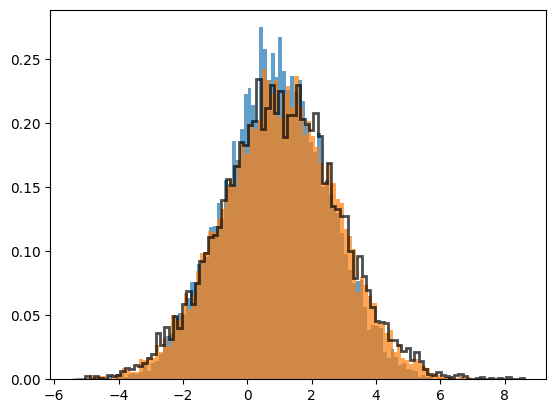

In [48]:
i = 0
plt.hist(np.random.multivariate_normal(mu, cov, 10000)[..., i], alpha=0.7, density=True, bins=100, histtype='step', lw=2, color='k');
plt.hist(np.random.multivariate_normal(mux, covx, 10000)[..., i], alpha=0.7, density=True, bins=100);
plt.hist(np.random.multivariate_normal(mux2, covx2, 10000)[..., i], alpha=0.7, density=True, bins=100);

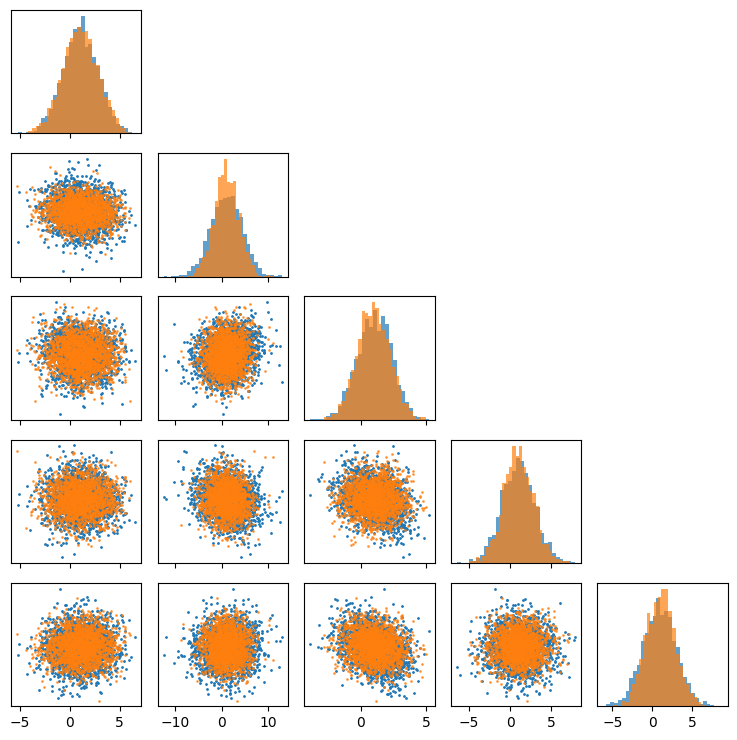

In [49]:
dplot = min(D, 5)
s = np.random.multivariate_normal(mu, cov, 2000)
s2 = np.random.multivariate_normal(mux2, covx2, 2000)

fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')

for i in range(dplot):
    for j in range(dplot):
        if i == j: 
            ax[i, i].hist(s[..., i], alpha=0.7, density=True, bins=30);
            ax[i, i].hist(s2[..., i], alpha=0.7, density=True, bins=30);
        elif j > i:
            ax[j, i].plot(s[..., i], s[..., j], '.', alpha=1., ms=2)
            ax[j, i].plot(s2[..., i], s2[..., j], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()


# BAM projection

In [142]:
from ls_gsm import LS_GSM
from gsm import GSM
from gsmvi.monitors import KLMonitor
from gsmvi.bam_lrproject import BAM_lrproject



In [50]:

##### Simple experiment for multivaraite Gaussian with dense covariance matrix
#####                                                                                                                                                         
def setup_model(D=10, rank=4):

    # setup a Gaussian target distribution                                                                                                                    
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)
    cov = np.matmul(L, L.T) + np.diag(np.random.normal(1, 1, D)*1e-1+1)
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples


D = 128
rank = 16
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)


In [51]:
lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


# alg = GSM(D, lp, lp_g)
# alg = GSM(D, lp_vmap, lp_g_vmap)
alg = LS_GSM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
niter = 500
monitor = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
meanfit, covfit = alg.fit(key,  batch_size=16, niter=niter, regf=lambda i: 100/(1+i), monitor=monitor)

Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 500
Iteration 350 of 500
Iteration 400 of 500
Iteration 450 of 500
Iteration 500 of 500


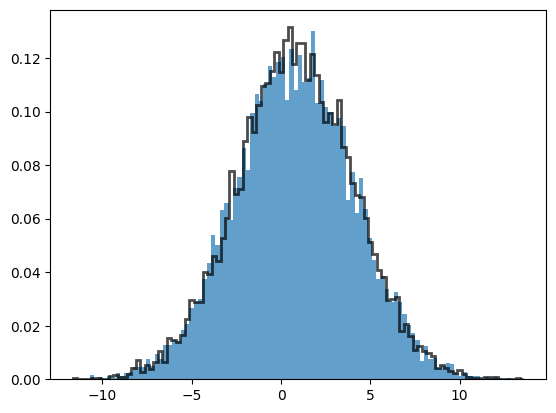

In [52]:
plt.hist(np.random.multivariate_normal(meanfit, covfit, 10000)[..., 0], bins=100, density=True, alpha=0.7);
plt.hist(ref_samples[..., 0], bins=100, density=True, alpha=0.7, histtype='step', lw=2, color='k');


In [53]:
# lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
# lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


# alg2 = BAM_lrproject(D, lp_vmap, lp_g_vmap)
# key = jax.random.PRNGKey(2)
# niter = 500
# monitor2 = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
# meanfit2, covfit2 = alg2.fit(key, rank=16, batch_size=16, n_project=256, niter=niter, regf=lambda x: 100, monitor=monitor2)

In [54]:
# plt.hist(np.random.multivariate_normal(meanfit2, covfit2, 10000)[..., 0], bins=100, density=True, alpha=0.7);
# plt.hist(ref_samples[..., 0], bins=100, density=True, alpha=0.7, histtype='step', lw=2, color='k');


## low rank fit function 

In [55]:

def _check_goodness(cov):
    is_good = False
    try:
        if (np.isnan(np.linalg.cholesky(cov))).any():
            nan_update.append(j)
        else:
            is_good = True
        return is_good
    except:
        return is_good



In [66]:
from ls_gsm import ls_gsm_lowrank_update

def low_rank_fit(key, D, lp, lp_g, rank, mean=None, cov=None, batch_size=16, 
                 niter=1000, nprint=10, regf=lambda i: 100/(1+i), retries=10, jitter=1e-6, monitor=None, verbose=True):


    if mean is None:
        mean = jnp.zeros(D)
    if cov is None:
        cov = jnp.identity(D)

    mean_lr, llambda, psi = None, None, None
    nevals = 0 
    update_function = jit(ls_gsm_lowrank_update)

    for i in range(niter + 1):
        if (i%(niter//nprint) == 0):
            print(f'Iteration {i} of {niter}')

        if monitor is not None:
            if (i%monitor.checkpoint) == 0:
                monitor(i, [mean, cov], lp, key, nevals=nevals)
                nevals = 0

        # Can generate samples from jax distribution (commented below), but using numpy is faster                                                         
        j = 0
        while True:         # Sometimes run crashes due to a bad sample. Avoid that by re-trying.                                                         
            try:
                key, key_sample = random.split(key, 2)
                np.random.seed(key_sample[0])
                samples = np.random.multivariate_normal(mean=mean, cov=cov, size=batch_size)
                vs = lp_g(samples)
                nevals += batch_size
                reg = regf(i)
                mean_new, cov_new = update_function(samples, vs, mean, cov, reg)
                cov_new += np.eye(D) * jitter # jitter covariance matrix                                                                             
                cov_new = (cov_new + cov_new.T)/2.
                break
            except Exception as e:
                if j < retries :
                    j += 1
                    print(f"Failed with exception {e}")
                    print(f"Trying again {j} of {retries}")
                else : raise e

        is_good = _check_goodness(cov_new)
        if is_good:
            mean, cov = mean_new, cov_new
            
            # x = np.random.multivariate_normal(mean, cov, 256)
            # if psi is None: 
            #     psi = jnp.diag(jnp.diag(cov))
            # if llambda is None: 
            #     llambda = np.linalg.eigh(cov)[1][:, :rank]
            #     # llambda = np.linalg.svd(cov)[0][:rank, :].T
            # _, llambda, psi = fit_lr_gaussian(x, rank, diagnosis=False,
            #                                      mu=mean, llambda=llambda, psi=psi, num_of_itr=200)
            x = np.random.multivariate_normal(mean, cov, 8)
            if psi is None: 
                psi = jnp.diag(jnp.diag(cov))
            if llambda is None: 
                llambda = np.random.normal(size=D*rank).reshape(D, rank)#*0. + 1.
                # llambda = np.random.normal(size=D*rank).reshape(D, rank)
                # llambda = np.linalg.eigh(cov)[1][:, :rank]
                # llambda = np.linalg.eigh(cov)[1][:, :rank]
                # llambda = cov[:, :rank]
            if i > 10: num_of_itr = 100
            else: num_of_itr = 100
            _, llambda, psi = fit_lr_gaussian2(x*0, mean, cov, num_of_latents=rank, diagnosis=False,
                                               llambda=llambda, psi=psi, num_of_itr=num_of_itr)
            cov = llambda@llambda.T + psi
        else:
            pass
            # if verbose: print("Bad update for covariance matrix. Revert")
            
        
      
    return mean, cov#, mean2, cov2


rank2 = int(rank)
ranklr = int(rank//4)
niter = 500
monitor2 = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
monitorlr = KLMonitor(batch_size=128, ref_samples=ref_samples, checkpoint=5)
meanfit2, covfit2 = low_rank_fit(key, D, lp_vmap, lp_g_vmap, rank=rank2, 
                                 niter=niter, monitor=monitor2, batch_size=min(D-1, 64), nprint=5)
meanfitlr, covfitlr = low_rank_fit(key, D, lp_vmap, lp_g_vmap, rank=ranklr, 
                                   niter=niter, monitor=monitorlr, batch_size=min(D-1, 16), nprint=5)


Iteration 0 of 500
Iteration 100 of 500
Iteration 200 of 500
Iteration 300 of 500
Iteration 400 of 500
Iteration 500 of 500
Iteration 0 of 500
Iteration 100 of 500
Iteration 200 of 500
Iteration 300 of 500
Iteration 400 of 500
Iteration 500 of 500


3


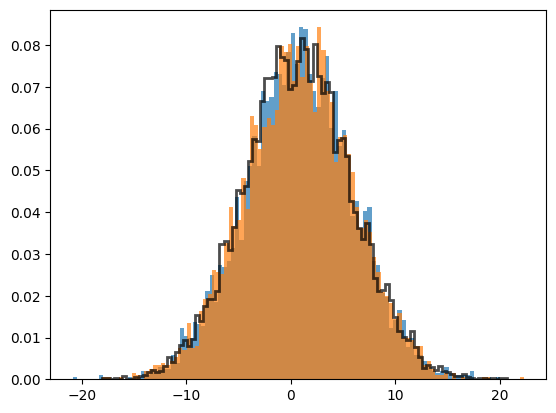

In [67]:
i = np.random.randint(0, D)
print(i)
plt.hist(np.random.multivariate_normal(meanfit, covfit, 5000)[..., i], bins=100, density=True, alpha=0.7);
plt.hist(np.random.multivariate_normal(meanfit2, covfit2, 5000)[..., i], bins=100, density=True, alpha=0.7);
# plt.hist(np.random.multivariate_normal(meanfitlr, covfitlr, 5000)[..., i], bins=100, density=True, alpha=0.7);
plt.hist(ref_samples[..., i], bins=100, density=True, alpha=0.7, histtype='step', lw=2, color='k');


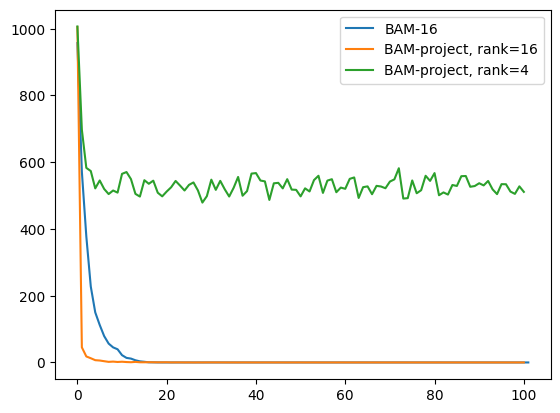

In [68]:
plt.plot(monitor.fkl, label=f'BAM-{rank}')
plt.plot(monitor2.fkl, label=f'BAM-project, rank={rank2}')
plt.plot(monitorlr.fkl, label=f'BAM-project, rank={ranklr}')
# plt.loglog()
plt.legend()

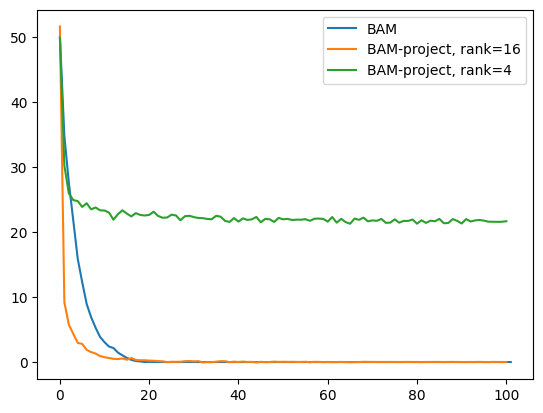

In [69]:
plt.plot(monitor.rkl, label='BAM')
plt.plot(monitor2.rkl, label=f'BAM-project, rank={rank2}')
plt.plot(monitorlr.rkl, label=f'BAM-project, rank={ranklr}')

# plt.loglog()
plt.legend()

[120  53  89  65  93]


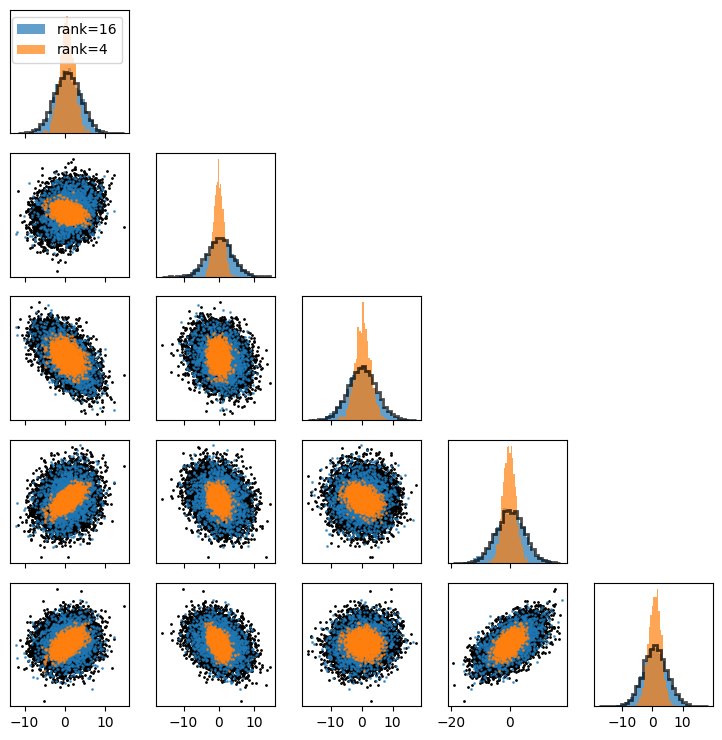

In [70]:
s = ref_samples[:, :] #np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)
s2 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
# s2 = np.random.multivariate_normal(meanfitlr, covfitlr, 2000)
s3 = np.random.multivariate_normal(meanfitlr, covfitlr, 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={rank2}");
            ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
            ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()

In [428]:
# fits = {}
# # ranks = [2, 4, 8, 12, 16, 20, 32]
# ranks = [ 4, 8, 12, 16, 20, 32]
# for r in ranks:
#     print(r)
#     monitorr = KLMonitor(batch_size=128, ref_samples=ref_samples, checkpoint=5)
#     meanfitr, covfitr = low_rank_fit(key, D, lp_vmap, lp_g_vmap, rank=r, 
#                                      niter=500, monitor=monitorr, batch_size=min(D-1, 16), nprint=2)
#     fits[r] = [meanfitr, covfitr, monitorr]
    
# # mean2, cov2, mean2lr, cov2lr = low_rank_fit(key, D, lp_vmap, lp_g_vmap, rank=D, niter=10)

4
Iteration 0 of 500
Iteration 250 of 500
Iteration 500 of 500
8
Iteration 0 of 500
Iteration 250 of 500
Iteration 500 of 500
12
Iteration 0 of 500
Iteration 250 of 500
Iteration 500 of 500
16
Iteration 0 of 500


KeyboardInterrupt: 

KeyError: 16

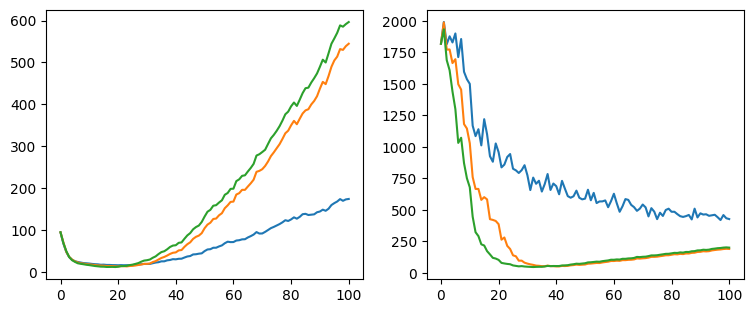

In [429]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3.5))

for r in ranks:
    ax[0].plot(fits[r][-1].rkl, label=f'rank={r}')
    ax[1].plot(fits[r][-1].fkl, label=f'rank={r}')

ax[0].plot(monitor.rkl, color='k')
ax[1].plot(monitor.fkl, color='k', label='BAM')
ax[1].legend(ncol=2)
for axis in ax:
    axis.grid(lw=0.4)
    axis.set_xlabel('number of iterations')
    # axis.loglog()
ax[0].set_ylabel('Reverse KL')
ax[1].set_ylabel('Forward KL')
plt.suptitle(f'Target- {D} dim Gaussian with $\Sigma=D+LL^T$, L={D}x{rank}')
plt.tight_layout()


[271 312 332 369 270]


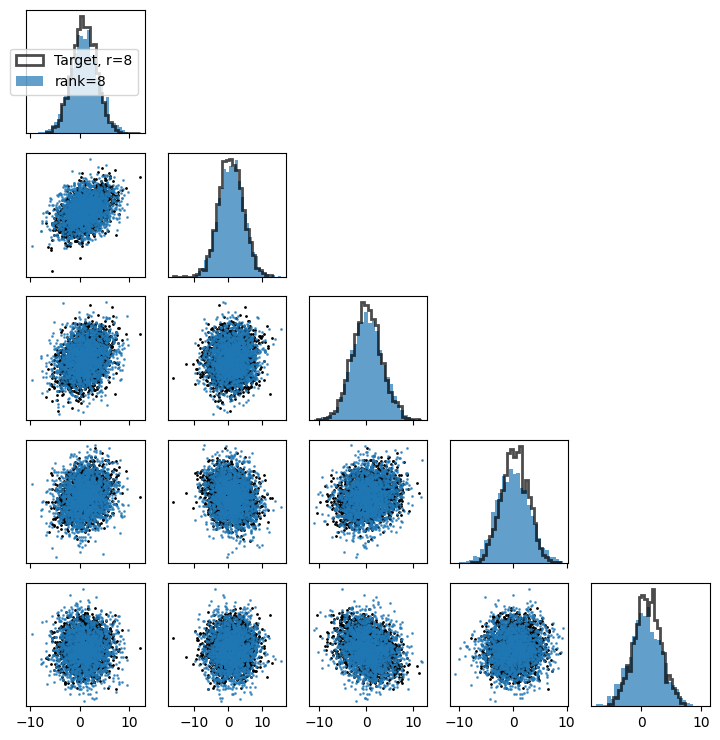

In [430]:
s = np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)

rplot = [rank]

ss = []
for r in rplot:
    meanfitr, covfitr = fits[r][:2]
    ss.append(np.random.multivariate_normal(meanfitr, covfitr, 2000))

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)

for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2, 
                          label=f'Target, r={rank}');
            for iss, s2 in enumerate(ss):
                ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={rplot[iss]}");
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            for iss, s2 in enumerate(ss):
                ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()

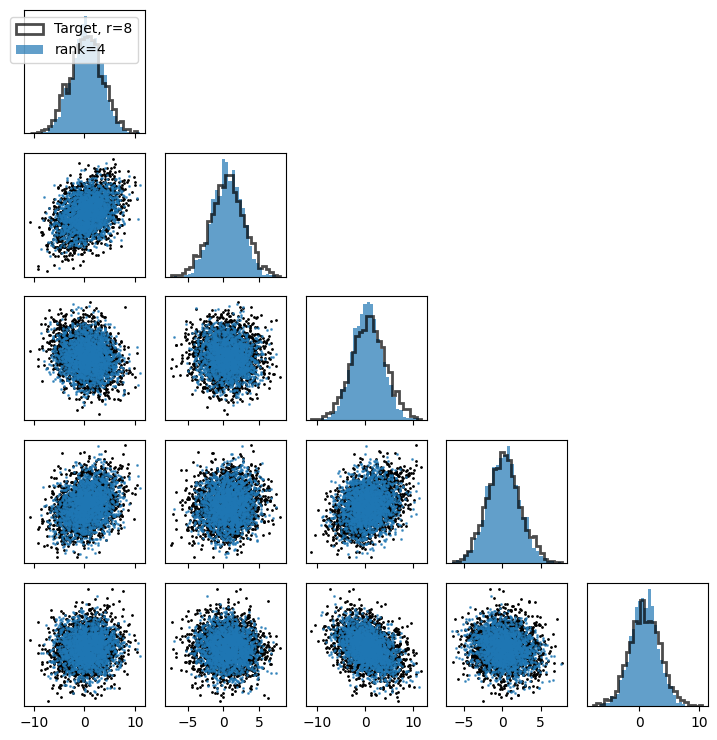

In [433]:
s = np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)

rplot = [4]

ss = []
for r in rplot:
    meanfitr, covfitr = fits[r][:2]
    ss.append(np.random.multivariate_normal(meanfitr, covfitr, 2000))

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')

for i in range(dplot):
    for j in range(dplot):
        if i == j: 
            ax[i, i].hist(s[..., i], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2, 
                          label=f'Target, r={rank}');
            for iss, s2 in enumerate(ss):
                ax[i, i].hist(s2[..., i], alpha=0.7, density=True, bins=30, label=f"rank={rplot[iss]}");
        elif j > i:
            ax[j, i].plot(s[..., i], s[..., j], '.', alpha=1., ms=2, color='k')
            for iss, s2 in enumerate(ss):
                ax[j, i].plot(s2[..., i], s2[..., j], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()

In [539]:
# s = np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)
# s3 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
# # s3 = np.random.multivariate_normal(meanfitlr, covfitlr, 2000)
# fig, ax = plt.subplots(D, D, figsize=(D*1.5, D*1.5))

# for i in range(D):
#     for j in range(D):
#         if i == j: 
#             ax[i, i].hist(s[..., i], alpha=0.7, density=True, bins=100, histtype='step', lw=2, color='k');
#             ax[i, i].hist(s2[..., i], alpha=0.7, density=True, bins=100, color='C0');
#             ax[i, i].hist(s3[..., i], alpha=0.7, density=True, bins=100, color='C1');
#         elif j > i:
#             ax[j, i].plot(s[..., i], s[..., j], '.', alpha=1., ms=2, color='k')
#             ax[j, i].plot(s2[..., i], s2[..., j], '.', alpha=0.7, ms=2, color='C0')
#             ax[j, i].plot(s3[..., i], s3[..., j], '.', alpha=0.7, ms=2, color='C1')
#         else: 
#             ax[j, i].set_axis_off()

# lr update2

In [518]:
from ls_gsm import ls_gsm_lowrank_update, compute_Q, get_sqrt
from time import time 

In [666]:
d = 32
k = 10
b = 8
L = np.random.normal(0, 1, k*d).reshape(d, k)*0.1
mean = np.random.normal(2, 1, d)
diag = np.diag(np.random.normal(2, 0.5, d))
cov = L@L.T + diag
x = np.random.multivariate_normal(mean, cov, 1000)

samples = np.random.random((b, d))
vs = np.random.random((b, d))
mu0 = np.random.random(d)
cov0 = np.random.random((d,d))
# A = np.random.normal(1, 1, d**2).reshape(d, d)
reg = 2 
mu1, cov1 = ls_gsm_lowrank_update(samples, vs, mu0, cov0, reg)

In [667]:
def BAM_lr_update2(samples, vs, mu0, llambda, psi, reg):


    assert len(samples.shape) == 2
    assert len(vs.shape) == 2
    S0 = np.diag(psi) + llambda@llambda.T
    B = samples.shape[0]
    xbar = jnp.mean(samples, axis=0)
    outer_map = jax.vmap(jnp.outer, in_axes=(0, 0))
    xdiff = samples - xbar
    C = jnp.mean(outer_map(xdiff, xdiff), axis=0)

    gbar = jnp.mean(vs, axis=0)
    gdiff = vs - gbar
    G = jnp.mean(outer_map(gdiff, gdiff), axis=0)

    U = reg * G + (reg)/(1+reg) * jnp.outer(gbar, gbar)
    V = S0 + reg * C + (reg)/(1+reg) * jnp.outer(mu0 - xbar, mu0 - xbar)

    # Form decomposition that is D x K                                                                                                                                                   
    Q = compute_Q((U, B))
    I = jnp.identity(B)
    VT = V.T
    A = VT.dot(Q)
    BB = 0.5*I + jnp.real(get_sqrt(A.T.dot(Q) + 0.25*I))
    BB = BB.dot(BB)
    CC = jnp.linalg.solve(BB, A.T)
    S, mu = CC, 0
    # S = VT - A @ CC
    # mu = 1/(1+reg) * mu0 + reg/(1+reg) * (jnp.matmul(S, gbar) + xbar)
    return mu, S


def BAM_lr_update3(samples, vs, mu0, llambda, psi, reg):

    ##############
    # print('new stuff now')
    assert len(samples.shape) == 2
    assert len(vs.shape) == 2
    B, D = samples.shape
    xbar = jnp.mean(samples, axis=0)
    gbar = jnp.mean(vs, axis=0)
    XT = (samples - xbar)/B**0.5  # shape BxD                                                                                                                                                
    GT = (vs - gbar)/B**0.5    # shape BxD                                                                                                                                                
    # print(XT.shape, GT.shape)

    U = jnp.concatenate([reg**0.5*GT.T,  ((reg)/(1+reg))**0.5 * gbar.reshape(-1, 1)], axis=1)
    Q = U.copy()
    # print('Q shape : ', Q.shape)
    
    R = jnp.concatenate([llambda, reg**0.5*XT.T, (reg/(1+reg))**0.5*(mu0-xbar).reshape(-1, 1)], axis=1)
    # V = S0 + reg * C + (reg)/(1+reg) * jnp.outer(mu0 - xbar, mu0 - xbar)
    # V = jnp.diag(psi) + R@R.T

    QTV = (Q.T@R)@R.T + (Q.T*psi)
    VTQ = (Q.T*psi).T + R@(R.T@Q)
    Id_Q = np.identity(QTV.shape[0])
    M = 0.5*Id_Q + get_sqrt(0.25*Id_Q + QTV@Q).real
    MM = np.linalg.pinv(M@M)
    S, mu = MM@QTV, 0
    # S = V - VTQ@MM@QTV
    # mu = 1/(1+reg) * mu0 + reg/(1+reg) * (jnp.matmul(S, gbar) + xbar)

    return mu, S

llambda = np.random.random((d, k))
psi = np.random.random(d)#*0 + 1.
# mu2, cov2 = BAM_lr_update2(samples, vs, mu0, cov0, reg);
cov0 = np.diag(psi) + llambda@llambda.T
mu1, cov1 = ls_gsm_lowrank_update(samples, vs, mu0, cov0, reg)
mu2, cov2 = BAM_lr_update2(samples, vs, mu0, llambda, psi, reg);
mu3, cov3 = BAM_lr_update3(samples, vs, mu0, llambda, psi, reg);

# np.allclose(cov2, cov3)

In [668]:
%timeit mu2, cov2 = BAM_lr_update2(samples, vs, mu0, llambda, psi, reg);


12.3 ms ± 59.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [504]:
%timeit mu2, cov2 = BAM_lr_update3(samples, vs, mu0, llambda, psi, reg);


2.15 ms ± 5.04 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [521]:
# k = 10
# b = 8

# t0, t1 = [], []
# ds = []
# for i in range(6, 13):
#     d = 2**i
#     print(d)
#     ds.append(d)
#     reg = 2 
#     samples = np.random.random((b, d))
#     vs = np.random.random((b, d))
#     mu0 = np.random.random(d)
#     llambda = np.random.random((d, k))
#     psi = np.random.random(d)#*0 + 1.
#     start = time()
#     for _ in range(10):
#         mu2, cov2 = BAM_lr_update2(samples, vs, mu0, llambda, psi, reg);
#     t0.append(time()-start)

#     start = time()
#     for _ in range(10):
#         mu3, cov3 = BAM_lr_update3(samples, vs, mu0, llambda, psi, reg);
#     t1.append(time()-start)


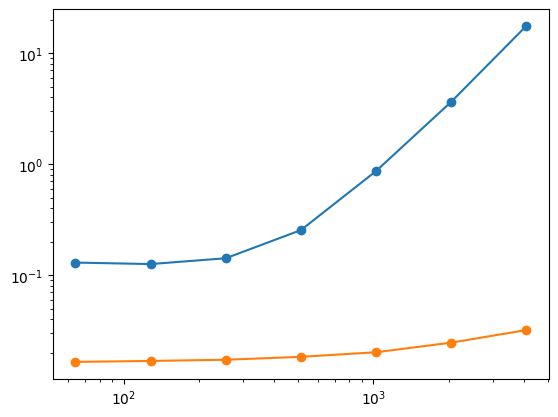

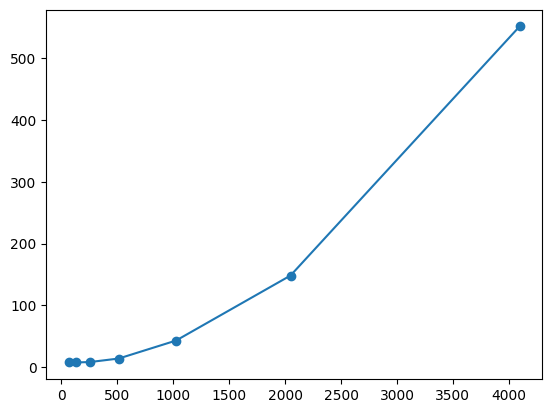

In [511]:
# plt.plot(ds, t0, marker='o')
# plt.plot(ds, t1, marker='o')
# plt.loglog()
# plt.show()
# plt.plot(ds, np.array(t0)/np.array(t1), marker='o')


In [677]:
# @jit
def em_exact_lowrank(llambda, psi, cov):
    D = llambda.shape[0]
    r = llambda.shape[1]
    psi_inv = jnp.diag(jnp.diagonal(psi)**-1)
    alpha = llambda.T@psi_inv    
    beta = jnp.linalg.pinv(np.identity(r) + alpha@llambda)
    gamma = cov@(alpha.T@beta.T)
    llambda_update = gamma @ jnp.linalg.pinv(beta + beta@alpha@gamma) 

    A = jnp.eye(D) - llambda_update @beta @ llambda.T @psi_inv
    M = A@cov@A.T + llambda_update @beta @llambda_update.T
    psi_update = jnp.diag(jnp.diagonal(M))
    
    return llambda_update, psi_update



#using mle for training
def fit_lr_gaussian2test(data, cov, num_of_latents,
                tolerance=0.001,num_of_itr=100, diagnosis=False, 
                llambda=None, psi=None):
        

    #cap the maximum number of iterations
    #initialize
    counter=0
    while counter < num_of_itr:
        print(counter)
        llambda, psi = em_exact_lowrank(llambda, psi, cov)
        counter+=1
    
    if diagnosis:
        print(f'{counter} iterations to reach convergence\n')
        
    return llambda, psi


In [37]:
B, D = 8, 32
K = 4
mean = np.random.random(D)
psi = np.random.random(D)
llambda = np.random.random((D, K))

In [39]:
eps = np.random.normal(0, 1, size=(B, D))
z =	np.random.normal(0, 1, size=(B, K))
samples = mean + psi**0.5 * eps + (llambda@z.T).T

In [43]:
(llambda@z.T).shape

(32, 8)

In [26]:

s0, s1 = np.random.normal(0, 1, size=(2, b, D))
s0.shape

(8, 64)

In [688]:
def BAM_lr_project_test(samples, vs, mu0, llambda, psi, reg,  num_of_itr = 2):

    ##############
    assert len(samples.shape) == 2
    assert len(vs.shape) == 2
    B, D = samples.shape
    K = llambda.shape[1]
    xbar = jnp.mean(samples, axis=0)
    gbar = jnp.mean(vs, axis=0)
    XT = (samples - xbar)/B**0.5  # shape BxD                                                                                                                                                
    GT = (vs - gbar)/B**0.5    # shape BxD                                                                                                                                                

    Q = jnp.concatenate([reg**0.5*GT.T,  ((reg)/(1+reg))**0.5 * gbar.reshape(-1, 1)], axis=1) #Dx(B+1)
    R = jnp.concatenate([llambda, reg**0.5*XT.T, (reg/(1+reg))**0.5*(mu0-xbar).reshape(-1, 1)], axis=1) #Dx(K+B+1)
    VTQ = (Q.T*psi).T + R@(R.T@Q) #Dx(B+1)
    QTV = (Q.T@R)@R.T + (Q.T*psi) #(B+1)xD
    Id_Q = np.identity(QTV.shape[0])
    M = 0.5*Id_Q + get_sqrt(0.25*Id_Q + QTV@Q).real
    MM = np.linalg.pinv(M@M)
    VTQM = VTQ@MM
    
    # V = jnp.diag(psi) + R@R.T
    # S = V - VTQ@MM@QTV
    # llambda_check, psi_check = fit_lr_gaussian2test(None, S, num_of_latents= K, llambda=llambda, psi=np.diag(psi), num_of_itr=num_of_itr)    
    # mu = 1/(1+reg) * mu0 + reg/(1+reg) * (jnp.matmul(S, gbar) + xbar)    
    mu = 1/(1+reg) * mu0 + reg/(1+reg) * (psi*gbar + R@(R.T@gbar) - VTQM@(QTV@gbar) + xbar)    
    
    # em project 
    def get_diag(u, v):
        return jax.vmap(jnp.dot, in_axes=[0, 0])(u, v)

    counter = 0 
    Id_K = np.identity(K)
    psi0 = psi.copy()
    first_term_1 = psi0 + get_diag(R, R) - get_diag(VTQM, QTV.T) #diag of cov for psi
    
    for counter in range(num_of_itr):
        psi_inv = psi**-1
        C = np.linalg.pinv(Id_K + (llambda.T *psi_inv)@llambda) #KxK
        J = C@(llambda.T*psi_inv) #KxD
        VJT = (J*psi0).T + R@(R.T@J.T) #DxK
        SJT = VJT - VTQM@(QTV@J.T)   #SigmaJT 
        # print(SJT.shape, VTQM.shape, (QTV@J.T).shape) 
        llambda_update = SJT @ np.linalg.pinv(C + J@SJT)
        # print(np.allclose(llambda_update, llambda_check))

        # psi update here        
        first_term_2 = -2* get_diag(SJT, llambda_update) #jax.vmap(jnp.dot, in_axes=[0, 1])(SJT, llambda_update.T)

        Mint = J@SJT
        def contractM(a):
            return a@Mint@a
        first_term_3 = jax.vmap(contractM, in_axes=[0])(llambda_update) 
        # Atest = llambda_update@J@S@J.T@llambda_update.T
        # print(first_term_3/np.diag(Atest))
        first_term = first_term_1 + first_term_2 + first_term_3
        
        lupdateC = llambda_update @C 
        second_term = get_diag(lupdateC, llambda_update) #jax.vmap(jnp.dot, in_axes=[0, 1])(lupdateC, llambda_update.T)
        psi_update = first_term + second_term
        
        llambda, psi = llambda_update, psi_update
        
        # A = jnp.eye(D) - llambda_update @C @ llambda.T *psi_inv
        # A = A@S@A.T + llambda_update @C @llambda_update.T        
        # print(psi_update/np.diag(A))
        
    # print(llambda_update/llambda_check)
    # print(psi_update/np.diag(psi_check))
    return mu, llambda, psi


llambda = np.random.random((d, k))
psi = np.random.random(d)#*0 + 1.
# mu2, cov2 = BAM_lr_update2(samples, vs, mu0, cov0, reg);
cov0 = np.diag(psi) + llambda@llambda.T
mu3, llambda_update, psi_upadte = BAM_lr_project_test(samples, vs, mu0, llambda, psi, reg, num_of_itr=5);



In [690]:
k = 10
b = 8

t0, t1 = [], []
ds = []
for i in range(6, 13):
    d = 2**i
    print(d)
    ds.append(d)
    reg = 2 
    samples = np.random.random((b, d))
    vs = np.random.random((b, d))
    mu0 = np.random.random(d)
    llambda = np.random.random((d, k))
    psi = np.random.random(d)#*0 + 1.
    start = time()
    for _ in range(10):
        mu2, cov2 = BAM_lr_update2(samples, vs, mu0, llambda, psi, reg);
    t0.append(time()-start)

    start = time()
    for _ in range(10):
        mu3, llambda_update, psi_update = BAM_lr_project_test(samples, vs, mu0, llambda, psi, reg);
    t1.append(time()-start)

ds = np.array(ds)
t0 = np.array(t0)
t1 = np.array(t1)

64
128
256
512
1024
2048
4096


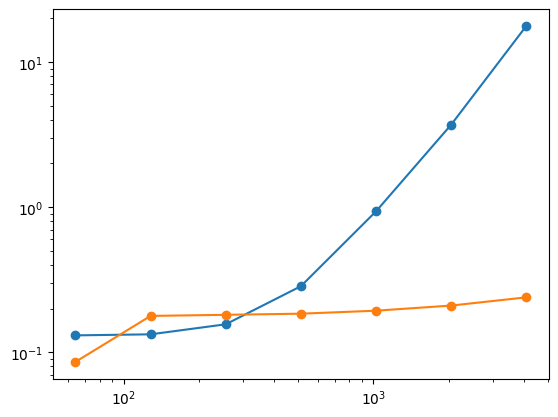

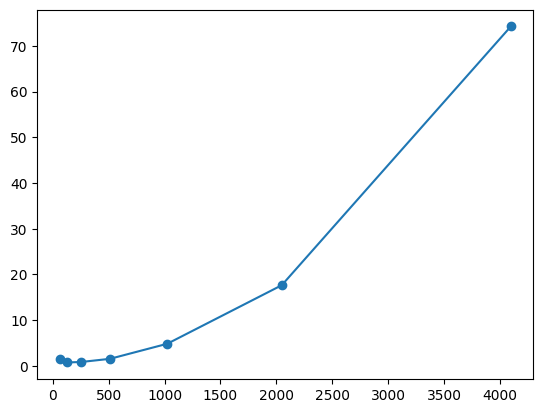

In [691]:
plt.plot(ds, t0, marker='o')
# plt.plot(ds, 1e-5*np.array(ds)**2, marker='o')
# plt.plot(ds, 1e-3*np.array(ds)**1, marker='o')
plt.plot(ds, t1, marker='o')
plt.loglog()
plt.show()
plt.plot(ds, np.array(t0)/np.array(t1), marker='o')


Text(0, 0.5, 'time for update')

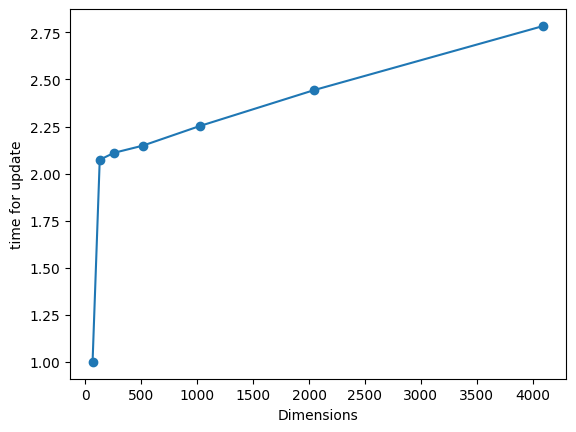

In [692]:
# plt.plot(ds, t0/t0[0], marker='o')
plt.plot(ds, t1/t1[0], marker='o')
plt.xlabel('Dimensions')
plt.ylabel('time for update')

In [712]:
from ls_gsm import ls_gsm_lowrank_update

def low_rank_fit_final(key, D, lp, lp_g, rank, mean=None, llambda=None, psi=None, batch_size=16, 
                 niter=1000, nprint=10, regf=lambda i: 100/(1+i), retries=10, jitter=1e-6, monitor=None, verbose=True):


    if mean is None:
        mean = jnp.zeros(D)

    nevals = 0 

    for i in range(niter + 1):
        if (i%(niter//nprint) == 0):
            print(f'Iteration {i} of {niter}')

        if monitor is not None:
            if (i%monitor.checkpoint) == 0:
                monitor(i, [mean, cov], lp, key, nevals=nevals)
                nevals = 0

        # Can generate samples from jax distribution (commented below), but using numpy is faster                                                         
        j = 0
        while True:         # Sometimes run crashes due to a bad sample. Avoid that by re-trying.                                                         
            try:
                key, key_sample = random.split(key, 2)
                np.random.seed(key_sample[0])
                samples = np.random.multivariate_normal(mean=mean, cov=cov, size=batch_size)
                vs = lp_g(samples)
                nevals += batch_size
                reg = regf(i)
                mean, llambda, psi = BAM_lr_project_test(samples, vs, mean, llambda=llambda, psi=psi, reg=reg, num_of_itr=5)
                
#                 mean_new, cov_new = update_function(samples, vs, mean, cov, reg)
#                 cov_new += np.eye(D) * jitter # jitter covariance matrix                                                                             
#                 cov_new = (cov_new + cov_new.T)/2.
                break
            except Exception as e:
                if j < retries :
                    j += 1
                    print(f"Failed with exception {e}")
                    print(f"Trying again {j} of {retries}")
                else : raise e

#         is_good = _check_goodness(cov_new)
#         if is_good:
#             mean, cov = mean_new, cov_new
            
#             # x = np.random.multivariate_normal(mean, cov, 256)
#             # if psi is None: 
#             #     psi = jnp.diag(jnp.diag(cov))
#             # if llambda is None: 
#             #     llambda = np.linalg.eigh(cov)[1][:, :rank]
#             #     # llambda = np.linalg.svd(cov)[0][:rank, :].T
#             # _, llambda, psi = fit_lr_gaussian(x, rank, diagnosis=False,
#             #                                      mu=mean, llambda=llambda, psi=psi, num_of_itr=200)
#             x = np.random.multivariate_normal(mean, cov, 8)
#             if psi is None: 
#                 psi = jnp.diag(jnp.diag(cov))
#             if llambda is None: 
#                 llambda = np.random.normal(size=D*rank).reshape(D, rank)#*0. + 1.
#                 # llambda = np.random.normal(size=D*rank).reshape(D, rank)
#                 # llambda = np.linalg.eigh(cov)[1][:, :rank]
#                 # llambda = np.linalg.eigh(cov)[1][:, :rank]
#                 # llambda = cov[:, :rank]
#             if i > 10: num_of_itr = 100
#             else: num_of_itr = 100
#             _, llambda, psi = fit_lr_gaussian2(x*0, mean, cov, num_of_latents=rank, diagnosis=False,
#                                                llambda=llambda, psi=psi, num_of_itr=num_of_itr)
#             cov = llambda@llambda.T + psi
        # else:
        #     pass
            # if verbose: print("Bad update for covariance matrix. Revert")
            
        
      
    return mean, llambda, psi#, mean2, cov2




D = 128
rank = 16
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)


rank2 = int(rank)
ranklr = int(rank//4)
niter = 500
# monitor2 = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
# monitorlr = KLMonitor(batch_size=128, ref_samples=ref_samples, checkpoint=5)
psi0 = np.random.random(D)
llambda0 = np.random.random((D, rank2))
meanfit2, llambda2, psi2 = low_rank_fit_final(key, D, lp_vmap, lp_g_vmap, rank=rank2, psi=psi0, llambda=llambda0,
                                 niter=niter, monitor=None, batch_size=min(D-1, 64), nprint=5)
covfit2 = np.diag(psi2) + llambda2@llambda2.T                             
llambda0 = np.random.random((D, ranklr))
meanfitlr, llambdalr, psilr = low_rank_fit_final(key, D, lp_vmap, lp_g_vmap, rank=ranklr, psi=psi0, llambda=llambda0,
                                   niter=niter, monitor=None, batch_size=min(D-1, 16), nprint=5)
covfitlr = np.diag(psilr) + llambdalr@llambdalr.T                             


Iteration 0 of 500
Iteration 100 of 500
Iteration 200 of 500
Iteration 300 of 500
Iteration 400 of 500
Iteration 500 of 500
Iteration 0 of 500
Iteration 100 of 500
Iteration 200 of 500
Iteration 300 of 500
Iteration 400 of 500
Iteration 500 of 500


[ 73 102  47  77 115]


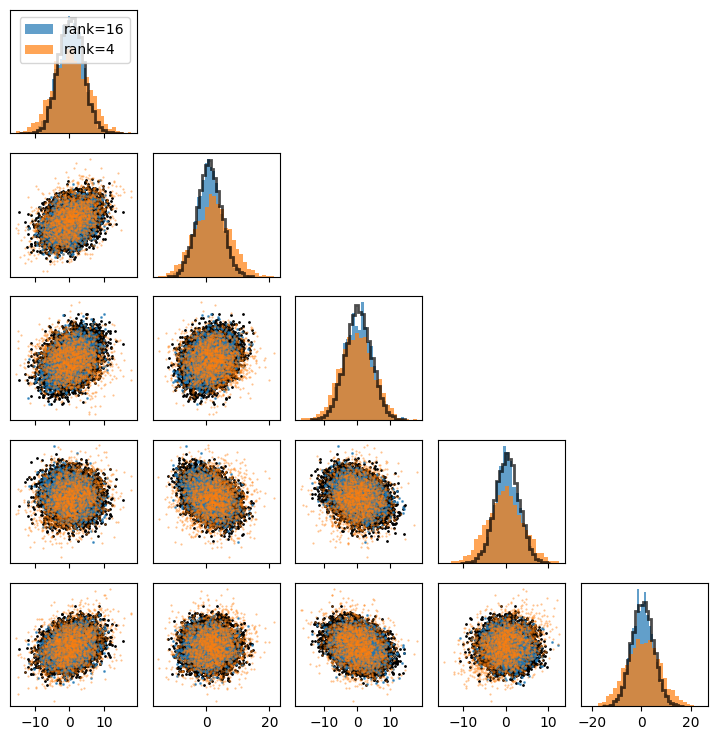

In [714]:
s = ref_samples[:, :] #np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)
s2 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
# s2 = np.random.multivariate_normal(meanfitlr, covfitlr, 2000)
s3 = np.random.multivariate_normal(meanfitlr, covfitlr, 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={rank2}");
            ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
            ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=1)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()

# logp

In [179]:
d = 512
k = 10
b = 8
L = np.random.normal(0, 1, k*d).reshape(d, k)*0.1
mean = np.random.normal(2, 1, d)
diag = np.diag(np.random.normal(2, 0.5, d))
cov = L@L.T + diag
x = np.random.multivariate_normal(mean, cov, 1000)

psi, llambda = np.diagonal(diag), L
# samples = np.random.random((b, d))
# vs = np.random.random((b, d))

In [186]:
def detm(psi, llambda):
    m = (llambda.T*(1/psi))@llambda
    m = np.identity(m.shape[0]) + m
    return jnp.linalg.det(m)*jnp.prod(psi)

def logp_lr(y, mu, psi, llambda):

    D, K = llambda.shape
    x = y - mu
    first_term = jnp.dot(x, x/psi)
    ltpsinv = llambda.T*(1/psi)
    m = jnp.identity(K) + ltpsinv@llambda
    minv = jnp.linalg.inv(m)
    res= (ltpsinv@x)
    second_term = res.T@minv@res
    logexp = -0.5 * (first_term - second_term)
    logdet = - 0.5 * jnp.log(jnp.linalg.det(m)*jnp.prod(psi))
    logp = logexp + logdet - 0.5*D*np.log(2*pi)
    return logp

# detm(psi, llambda), np.linalg.det(cov)


In [187]:
i = np.random.randint(1000)
print(i)
logp_lr(x[i], mean, psi, llambda)/ MultivariateNormal(mean, cov).log_prob(x[i])

530


Array(1., dtype=float64)

In [188]:
%timeit logp_lr(x[i], mean, psi, llambda)


544 µs ± 7.54 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [189]:
%timeit MultivariateNormal(mean, cov).log_prob(x[i])

4.55 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [190]:
%timeit jnp.linalg.det(cov)

4.31 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [191]:
%timeit detm(psi, llambda)

176 µs ± 2.03 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
